## Project Overview
This project involves analyzing Amazon Alexa product reviews to predict customer sentiment (positive or negative feedback). The dataset used for this analysis contains customer reviews, ratings, feedback (positive or negative), and variations of the product. The main objective is to preprocess the text data, vectorize it, and use various machine learning models to classify the reviews based on the feedback. 

## Key Steps in the Project
1. **Loading and Exploring the Dataset**: The dataset is loaded, and various exploratory data analysis (EDA) techniques are applied to understand the distribution of ratings, feedback, and variations.
2. **Data Preprocessing**: This includes handling missing values, stemming the text data, and creating new features like the length of each review.
3. **Text Vectorization**: The reviews are converted into numerical format using the `CountVectorizer`.
4. **Data Splitting and Scaling**: The dataset is split into training and testing sets, and the feature values are scaled using `MinMaxScaler`.
5. **Model Training and Evaluation**: Several machine learning models (Logistic Regression, Linear SVC, XGBoost, Decision Tree, Random Forest, Gradient Boosting) are trained and evaluated on the test data. The performance of each model is assessed using accuracy, confusion matrix, and classification report.
6. **Model Selection and Saving**: The best-performing model (Decision Tree Classifier) is selected and saved along with the scaler and vectorizer using `joblib` for future use.

## Benefits and Key Techniques
- **Text Preprocessing**: Techniques such as stemming and removing stop words improve the quality of the text data for better model performance.
- **Visualization**: Word clouds, bar charts, and pie charts are used to visualize the data distribution and insights effectively.
- **Model Evaluation**: Detailed evaluation metrics provide a comprehensive understanding of model performance, helping to select the most appropriate model.
- **Reusability**: Saving the trained model, scaler, and vectorizer ensures that the model can be reused without retraining, making the solution efficient and scalable.

In [1]:
# Load dependencies
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from copy import deepcopy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
StopWords = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib as jb
import os

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load data

In [7]:
# Load dataset
df = pd.read_csv('PrepareModel\\amazon_alexa.tsv', delimiter = '\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
# Show shape of the dataset
df.shape

(3150, 5)

In [4]:
# Show some information about dataset to show number of null values and data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


# Exploratory data analysis

In [78]:
# Check for missing values to handle it if exist
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [17]:
# Print the missing values samples
df[df['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [79]:
# Handle missing values
df.dropna(inplace = True)

# Show sum of all none values after handling it
df.isnull().sum().sum()

0

In [20]:
# Show columns names and its types
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
dtype: object

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


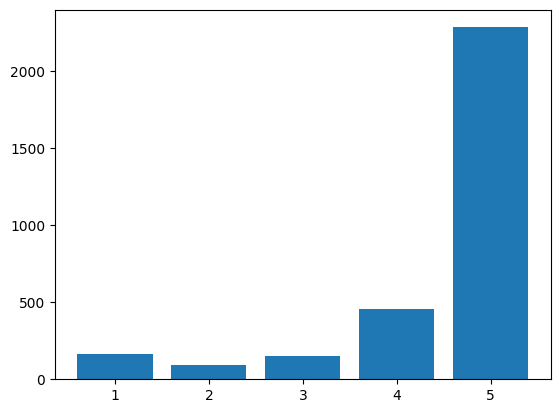

In [25]:
# Explore rating column
rating_counts = df['rating'].value_counts()
print(rating_counts)
plt.bar(rating_counts.index, rating_counts)
plt.show()

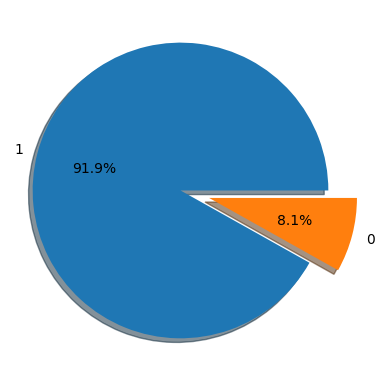

In [41]:
# Explore feedback column to check about unbalanced
feedback_counts = df['feedback'].value_counts()
plt.pie(feedback_counts, labels = feedback_counts.index, explode = [0.1,0.1], shadow = True, autopct = '%1.1f%%')
plt.show()

In [40]:
# Show first of positive and negative feedbacks
neg_review0 = df[df['feedback'] == 0].iloc[0]['verified_reviews']
print("negative feedback: ", neg_review0, '\n')
pos_review0 = df[df['feedback'] == 1].iloc[0]['verified_reviews']
print("positive feedback: ", pos_review0)

negative feedback:  It's like Siri, in fact, Siri answers more accurately then Alexa.  I don't see a real need for it in my household, though it was a good bargain on prime day deals. 

positive feedback:  Love my Echo!


In [43]:
# Show ratings for each feedback
ratings_neg = df[df['feedback'] == 0]['rating'].value_counts()
print("ratings of negative feedbacks\n",ratings_neg, '\n')

ratings_pos = df[df['feedback'] == 1]['rating'].value_counts()
print("ratings of positive feedbacks\n",ratings_pos)

ratings of negative feedbacks
 rating
1    161
2     95
Name: count, dtype: int64 

ratings of positive feedbacks
 rating
5    2286
4     455
3     152
Name: count, dtype: int64


variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


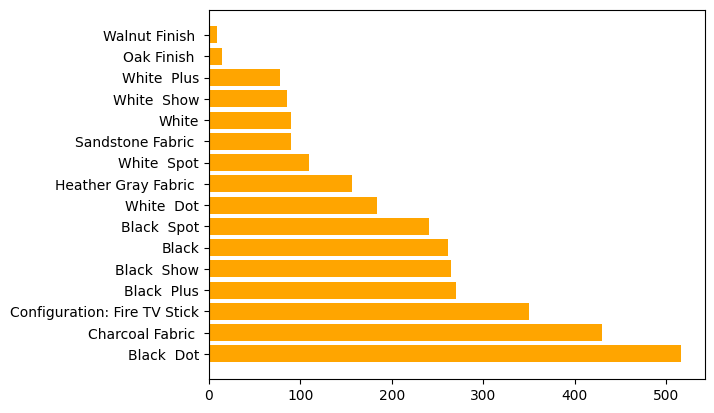

In [54]:
# Explore variation column
variation_counts = df['variation'].value_counts()
print(variation_counts)
plt.barh(variation_counts.index, variation_counts, color = 'orange')
plt.show()

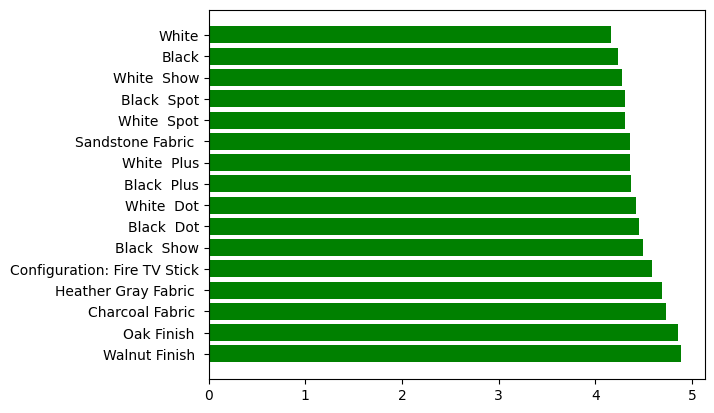

In [61]:
# Show mean rating according to variation column
average_ratings = df.groupby('variation')['rating'].mean().sort_values(ascending = False)
plt.barh(average_ratings.index, average_ratings, color = 'green')
plt.show()

0    Love my Echo!
Name: verified_reviews, dtype: object
13
       verified_reviews
count       3149.000000
mean         132.090187
std          182.114569
min            1.000000
25%           30.000000
50%           74.000000
75%          165.000000
max         2851.000000


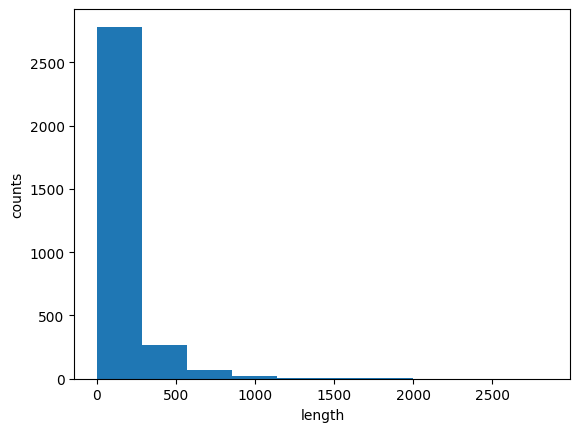

In [67]:
# Create legnth variable to store the lengh of each review
lengths = df['verified_reviews'].apply(len)
print(df['verified_reviews'][:1])
print(lengths[0])
print(pd.DataFrame(lengths).describe())
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('counts')
plt.show()

In [73]:
# Create word cloud
wc = WordCloud(background_color='white', max_words = 50)

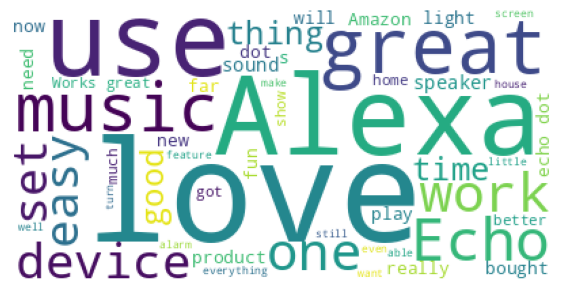

In [74]:
# Combine all reviews together
reviews = ' '.join([review for review in df['verified_reviews']])

# Visualize word cloud for all data
plt.figure(figsize = (7,7))
plt.imshow(wc.generate(reviews))
plt.axis('off')
plt.show()

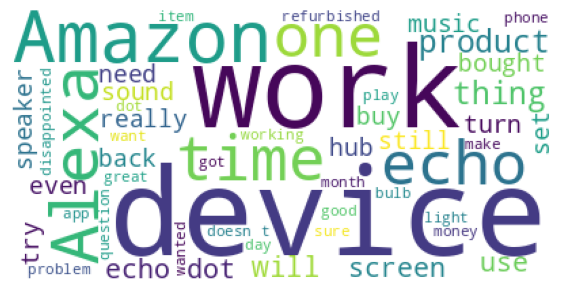

In [75]:
# Visualize word cloud for data with negative feedback
neg_reviews = ' '.join([review for review in df[df['feedback'] == 0]['verified_reviews']])
# Visualize word cloud
plt.figure(figsize = (7,7))
plt.imshow(wc.generate(neg_reviews))
plt.axis('off')
plt.show()

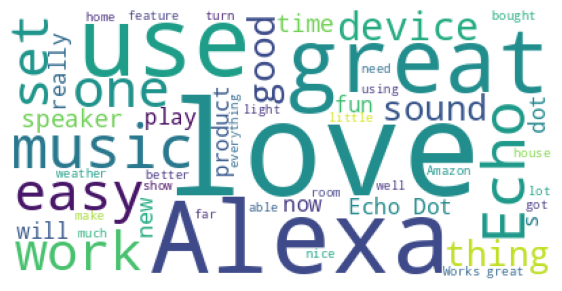

In [76]:
# Visualize word cloud for data with positive feedback
pos_reviews = ' '.join([review for review in df[df['feedback'] == 1]['verified_reviews']])
# Visualize word cloud
plt.figure(figsize = (7,7))
plt.imshow(wc.generate(pos_reviews))
plt.axis('off')
plt.show()

# Data Preprocessing

In [80]:
# Take copy from the original dataset
df_processed = deepcopy(df)

## Stemming data

In [81]:
# Create function to take the content and stemmer and stem it
def stemming(content, stemmer):
    # Remove non-alphabetical characters
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    
    # Convert sentences into lowercase sentences and split each into words
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    
    # Prepare stop words
    stop_words = set(stopwords.words('english'))
    # Stem words and remove stop words
    stemmed_content = [stemmer.stem(word) for word in stemmed_content if word not in stop_words]
    stemmed_content = ' '.join(stemmed_content)
    
    return stemmed_content

In [82]:
df_processed['verified_reviews'].head()

0                                        Love my Echo!
1                                            Loved it!
2    Sometimes while playing a game, you can answer...
3    I have had a lot of fun with this thing. My 4 ...
4                                                Music
Name: verified_reviews, dtype: object

In [83]:
# Create stemmer
stemmer = PorterStemmer()

In [84]:
# Apply stemming function to the 'text' column in DataFrame
df_processed['verified_reviews'] = df_processed['verified_reviews'].apply(lambda x: stemming(x, stemmer))

In [129]:
df_processed['verified_reviews'].head()

0                                            love echo
1                                                 love
2    sometim play game answer question correctli al...
3    lot fun thing yr old learn dinosaur control li...
4                                                music
Name: verified_reviews, dtype: object

## Vectorize data

In [130]:
# Create vectorizer
vectorizer = CountVectorizer(max_features = 2500)

# Vectorize train and test data
X = vectorizer.fit_transform(df_processed['verified_reviews']).toarray()

In [139]:
# Show x train after vectorization
print(X[:3])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Split data

In [140]:
# Get label data
Y = df_processed['feedback']
print(f'x shape {X.shape}')
print(f'y shape {Y.shape}')

x shape (3149, 2500)
y shape (3149,)


In [162]:
# Split data into train and test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify = Y, train_size = 0.7, random_state = 42)
print(f'x train shape {x_train.shape}, x test shape {x_test.shape}')
print(f'y train shape {y_train.shape}, y test shape {y_test.shape}')

x train shape (2204, 2500), x test shape (945, 2500)
y train shape (2204,), y test shape (945,)


## Scaling data

In [163]:
# Create scaler
scaler = MinMaxScaler()

# Scale train and test data
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Modeling

In [105]:
# Function to perform the model functionalities
def fit_predict(classifier, x_train, y_train, x_test, y_test):
    
    # Make model fit data
    classifier.fit(x_train, y_train)
    
    # Get Score on train and test data
    train_score = classifier.score(x_train, y_train)
    test_score = classifier.score(x_test, y_test)
    print(f'train score is {train_score}, test score is {test_score}')
    
    # Make model predict on test data
    test_prediction = classifier.predict(x_test)
    # Get accuracy, confusion matrix and classification report
    accuracy = accuracy_score(y_test, test_prediction) 
    cf_matrix = confusion_matrix(y_test, test_prediction)
    cl_report = classification_report(y_test, test_prediction)
    
    # Plot confusion matrix
    plt.figure(figsize=(7,7))
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Show accuracy and classification report
    print(f'accuracy: {accuracy}\nclassification report:\n{cl_report}', '\n\n')
    
    return classifier

In [165]:
# Put all required models that can fit this problem
models = {
    'LogisticRegression': LogisticRegression(),
    'LinearSVC': LinearSVC(),
    'XGBClassifier':XGBClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(),
    'RandomForestClassifier':RandomForestClassifier(),
    'GradientBoostingClassifier':GradientBoostingClassifier()
}

LogisticRegression:

train score is 0.9623411978221416, test score is 0.9248677248677248


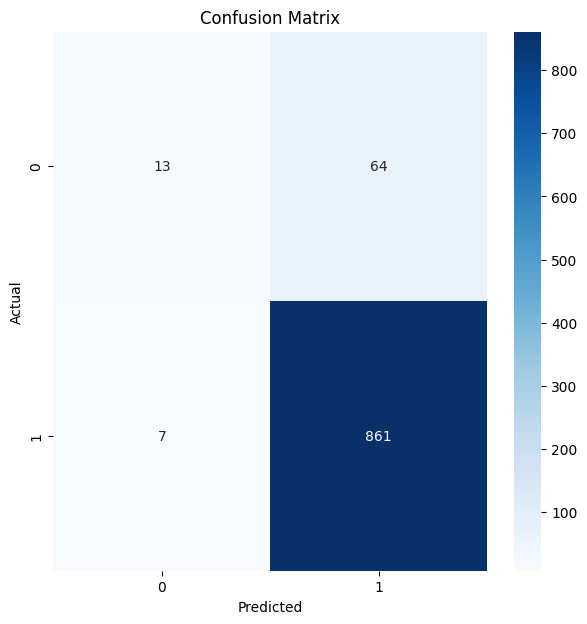

accuracy: 0.9248677248677248
classification report:
              precision    recall  f1-score   support

           0       0.65      0.17      0.27        77
           1       0.93      0.99      0.96       868

    accuracy                           0.92       945
   macro avg       0.79      0.58      0.61       945
weighted avg       0.91      0.92      0.90       945
 


LinearSVC:

train score is 0.9891107078039928, test score is 0.9333333333333333


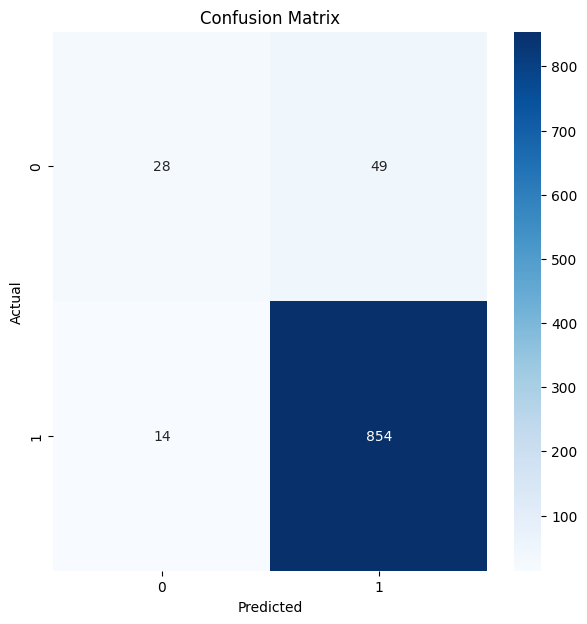

accuracy: 0.9333333333333333
classification report:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        77
           1       0.95      0.98      0.96       868

    accuracy                           0.93       945
   macro avg       0.81      0.67      0.72       945
weighted avg       0.92      0.93      0.92       945
 


XGBClassifier:

train score is 0.9732304900181489, test score is 0.9343915343915344


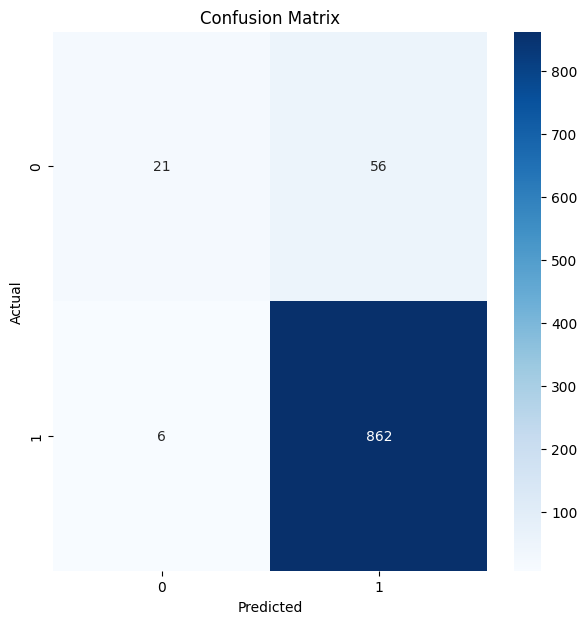

accuracy: 0.9343915343915344
classification report:
              precision    recall  f1-score   support

           0       0.78      0.27      0.40        77
           1       0.94      0.99      0.97       868

    accuracy                           0.93       945
   macro avg       0.86      0.63      0.68       945
weighted avg       0.93      0.93      0.92       945
 


DecisionTreeClassifier:

train score is 0.9927404718693285, test score is 0.926984126984127


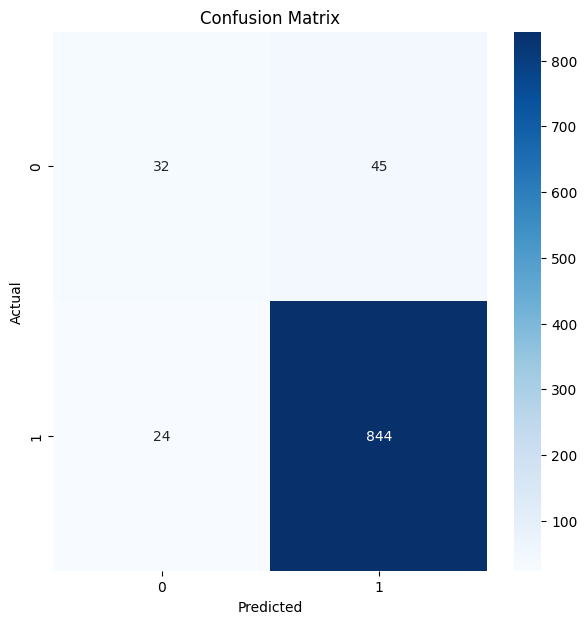

accuracy: 0.926984126984127
classification report:
              precision    recall  f1-score   support

           0       0.57      0.42      0.48        77
           1       0.95      0.97      0.96       868

    accuracy                           0.93       945
   macro avg       0.76      0.69      0.72       945
weighted avg       0.92      0.93      0.92       945
 


RandomForestClassifier:

train score is 0.9922867513611615, test score is 0.9375661375661376


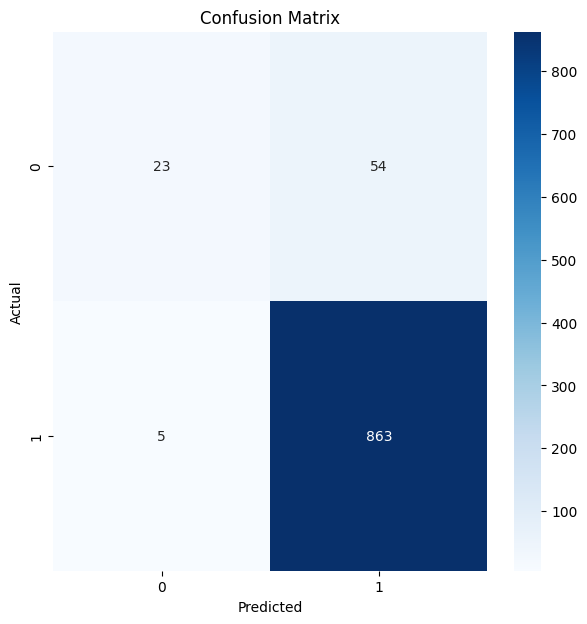

accuracy: 0.9375661375661376
classification report:
              precision    recall  f1-score   support

           0       0.82      0.30      0.44        77
           1       0.94      0.99      0.97       868

    accuracy                           0.94       945
   macro avg       0.88      0.65      0.70       945
weighted avg       0.93      0.94      0.92       945
 


GradientBoostingClassifier:

train score is 0.9587114337568058, test score is 0.9259259259259259


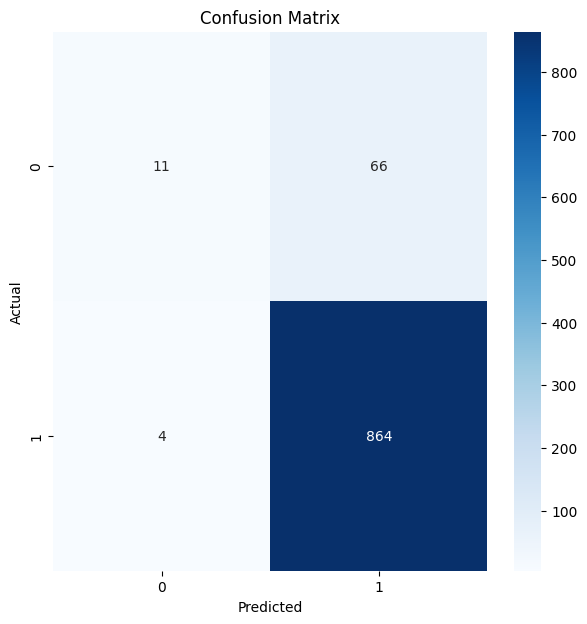

accuracy: 0.9259259259259259
classification report:
              precision    recall  f1-score   support

           0       0.73      0.14      0.24        77
           1       0.93      1.00      0.96       868

    accuracy                           0.93       945
   macro avg       0.83      0.57      0.60       945
weighted avg       0.91      0.93      0.90       945
 




In [166]:
trained_models = {}
for name, model in models.items():
    print(f'{name}:\n')
    model = fit_predict(model, x_train_scaled, y_train, x_test_scaled, y_test)
    trained_models[name] = deepcopy(model)

# Saving best model
Based on the previous results, the Decision Tree Classifier model is the best one on the test data with accuracy 93% with reducing False Negative.

In [167]:
DecisionTreeClassifier = trained_models['DecisionTreeClassifier']

# Define file paths
model_path = 'PrepareModel/decisiontree.sav'
scaler_path = 'PrepareModel/minmaxscaler.sav'
vectorizer_path = 'PrepareModel/vectorizer.sav'

# Save the Decision Tree Classifier if not already saved
if not os.path.exists(model_path):
    jb.dump(DecisionTreeClassifier, model_path)
    print(f'DecisionTreeClassifier saved to {model_path}')

# Save the MinMaxScaler if not already saved
if not os.path.exists(scaler_path):
    jb.dump(scaler, scaler_path)
    print(f'MinMaxScaler saved to {scaler_path}')

# Save the CountVectorizer if not already saved
if not os.path.exists(vectorizer_path):
    jb.dump(vectorizer, vectorizer_path)
    print(f'CountVectorizer saved to {vectorizer_path}')

['vectorizer.sav']

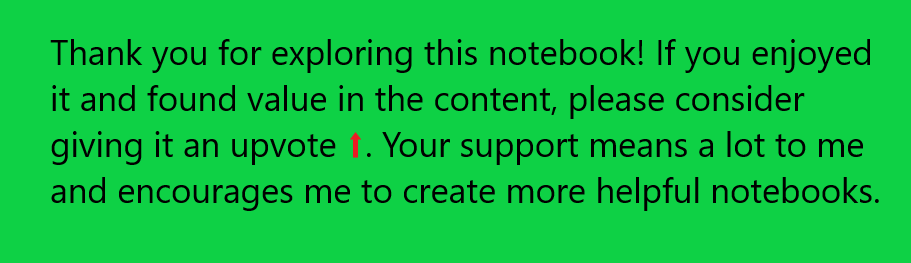